In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
from skimage import io
from metadata import Metadata
from image_show import *
from cell_label import *

In [5]:
md = Metadata('/Users/rfor10/Downloads/mcf10a_v2_serum2_2018Aug01/')
posnames = md.posnames

In [6]:
import numpy as np
from skimage.exposure import rescale_intensity
def imadjust(img, low=0.01, high = 0.90):
    low, high = np.percentile(img, [low*100, high*100])
    img = rescale_intensity(img, (low, high))
    return img

In [7]:
def flatfield_correct(img, flatfield, drange=(1, 2**16), camera_constant=100):
    flatfield = (flatfield+100)/np.median(flatfield.flatten())
    img = (img)/flatfield
    np.place(img, img>drange[1], drange[1])
    np.place(img, img==float('inf'), drange[1])
    np.place(img, img<drange[0], drange[0])
    return img

In [8]:
from scipy.ndimage import gaussian_filter
from skimage.feature import corner_peaks
from skimage.measure import label, regionprops
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.filters import threshold_otsu

In [9]:
from skimage.morphology import binary_dilation, diamond

In [19]:
nikon_edge_mask = io.imread('/Users/rfor10/repos/PyImages/microscope_config/nikon_edge_mask.tif')

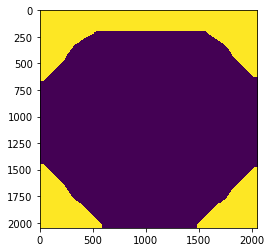

In [14]:
nikon_edge_mask = edge_mask
nikon_edge_mask[500:1500, 500:1500] = 0
nikon_edge_mask[1500:1800, 1200:1600] = 0
for i in range(4):
    nikon_edge_mask = binary_dilation(nikon_edge_mask, diamond(50))
nikon_edge_mask[0:200, :] = 1
plt.imshow(nikon_edge_mask)

In [15]:
from skimage import io

In [17]:
nikon_edge_mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [18]:
io.imsave('/Users/rfor10/repos/PyImages/microscope_config/nikon_edge_mask.tif', nikon_edge_mask.astype('uint8'))

/Users/rfor10/anaconda3/envs/pyspots/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /Users/rfor10/repos/PyImages/microscope_config/nikon_edge_mask.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [10]:
import skimage
from skimage.morphology import remove_small_objects
from collections import defaultdict
from skimage.feature import register_translation
from skimage.transform import warp, AffineTransform

In [273]:
nucs, nuc_md = md.stkread(Channel=nuc_channel, Position=pos, metadata=True)
nuc_tps = nuc_md['TimestampFrame'].values

opening img_000000001_000000000_DeepBlue_000_001.tif

In [11]:
class Registration(object):
    def __init__(self, tforms=dict()):
        self.tforms=tforms
    def find_translation(self, src, dest, timepoint):
        tvec = register_translation(dest, src)
        tform = AffineTransform(translation=(tvec[0][1], tvec[0][0]))
        self.tforms[timepoint] = tform
        return tform
    def apply_tform(self, dest, dest_timepoint=None, order=1):
        dest = dest.copy()
        if isinstance(dest_timepoint, skimage.transform._geometric.AffineTransform):
            pass
        else:
            dest_timepoint = self.tforms[dest_timepoint]
        dest = warp(dest, dest_timepoint, preserve_range=True, order=order)
        return dest
    def map_and_apply_tforms(self, dest_stack, dest_timepoints, grouping='nearest', order=1):
        dest_stack = dest_stack.copy()
        source_timepoints = list(self.tforms.keys())
        if grouping == 'nearest':
            grouping = []
            for dest_tp in dest_timepoints:
                tdist = np.abs(np.subtract(source_timepoints, dest_tp))
                closest_source_tp = np.argmin(tdist)
                grouping.append(source_timepoints[closest_source_tp])
        elif isinstance(grouping, dict):
            # Assume dictionary is mapping of stk timepoints to tforms timepoints
            grouping = sorted(grouping.items(), key=lambda x: x[0])
            dest_timepoints, grouping = zip(*grouping)
        dest_stack = np.stack([self.apply_tform(dest_stack[:,:,i], self.tforms[grouping[i]], order=order) 
                              for i in range(dest_stack.shape[2])], axis=2)
        return dest_stack

def group_timepoints_by_acq(md_table, channel1, channel2):
    tp1 = md_table[md_table.Channel==channel1].TimestampFrame.values
    tp2 = md_table[md_table.Channel==channel2].TimestampFrame.values
    if len(tp2)<len(tp1):
        print(len(tp1), len(tp2))
        tp1, tp2 = tp2, tp1
        source, dest = channel2, channel1
    else:
        source, dest = channel1, channel2
    groups = md_table.groupby('acq')
    grouping = {}
    print(source, dest)
    missing_dests = []
    for acq, groupdf in groups:
        source_timepoints = groupdf[groupdf.Channel==source].TimestampFrame.values
        dest_timepoints = groupdf[groupdf.Channel==dest].TimestampFrame.values
        if len(source_timepoints)==0:
            missing_dests = np.concatenate((dest_timepoints, missing_dests))
            continue
        else:
            dest_timepoints = np.concatenate((dest_timepoints, missing_dests))
            missing_dests = []
#         acq_grouping = []
        for dest_tp in dest_timepoints:
            tdist = np.abs(np.subtract(source_timepoints, dest_tp))
            closest_source_tp = np.argmin(tdist)
#             acq_grouping.append(source_timepoints[closest_source_tp])
            grouping[dest_tp] = source_timepoints[closest_source_tp]
    
    return grouping
    

In [12]:
nuc_channel = 'DeepBlue'
cyto_plasm_channel = 'Yellow'
nuc_smooth_sigma = (2, 2)
min_dist_between_nuclei = 5
peak_treshold_relative = 0
flt_field = io.imread('/Users/rfor10/Downloads/mcf10a_v2_serum2_2018Aug01/flt_DeepBlue_10x_1x.tif')

cell_labels = {}
tstart = time.time()
for pos in posnames:
    print('Segmenting Started for', pos, 'elapsed time: ', time.time()-tstart)
    lbl = CellLabel('/Users/rfor10/Downloads/mcf10a_v2_serum2_2018Aug01/')
    nucs, nuc_md = md.stkread(Channel=nuc_channel, Position=pos, metadata=True)
    nuc_tps = nuc_md['TimestampFrame'].values
    nucs = np.stack([flatfield_correct(nucs[:,:,i], flt_field) for i in range(nucs.shape[2])], axis=2)
    nuc_reg = Registration()
    for n_i in range(nucs.shape[2]):
        cur_nuc = nucs[:,:,n_i]
        # Register nuclei for any large shifts
        
        np.place(cur_nuc, nikon_edge_mask, 1)
        np.place(cur_nuc, remove_small_objects(cur_nuc>np.percentile(cur_nuc, 99.5), min_size=225), 1)
        if n_i == 0:
            nuc_reg.tforms[nuc_tps[n_i]] = AffineTransform(translation=(0,0))
            #cur_nuc = nucs[:,:,n_i].copy()
        else:
            nuc_reg.find_translation(cur_nuc, nucs[:,:,0], nuc_tps[n_i])
            nuc_reg.apply_tform(cur_nuc, nuc_tps[n_i])            
        smoothed_nuc = gaussian_filter(cur_nuc, nuc_smooth_sigma)
        nuc_peaks = corner_peaks(smoothed_nuc, min_distance=min_dist_between_nuclei, indices=False,
                                 threshold_rel=peak_treshold_relative, exclude_border=True)
        nuc_lbls = watershed(smoothed_nuc*-1, label(nuc_peaks), mask=cur_nuc>threshold_otsu(cur_nuc))
        nuc_lbls = remove_small_objects(nuc_lbls, min_size=80)
        lbl.addLabel(nuc_lbls, 'nuc', n_i)
    trks = lbl.trackLabels()
    lbl.relabel(trks)
    cell_labels[pos] = lbl
    cyto_channel, cyto_md = md.stkread(Channel='Yellow', Position=pos, metadata=True)
    groupdict = group_timepoints_by_acq(md.image_table[md.image_table.Position==pos], 'Yellow', 'DeepBlue')
    cyto_channel = nuc_reg.map_and_apply_tforms(cyto_channel, cyto_md.TimestampFrame.values,
                                                grouping=groupdict)
        # Measure images in stks
    break

Segmenting Started for TL elapsed time:  0.00043582916259765625
opening img_000000001_000000000_DeepBlue_000_001.tif

/Users/rfor10/anaconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'nikon_edge_mask' is not defined

In [ ]:
print('hi')

In [52]:
groupdict = group_timepoints_by_acq(md.image_table[md.image_table.Position==pos], 'DeepBlue', 'Yellow')
cyto_channel = nuc_reg.map_and_apply_tforms(cyto_channel, cyto_md.TimestampFrame.values,
                                            grouping=groupdict)

DeepBlue Yellow


KeyError: 737273.4979610802

> <ipython-input-43-4eb982dd1821>(31)<listcomp>()
     29             dest_timepoints, grouping = zip(*grouping)
     30         dest_stack = np.stack([self.apply_tform(dest_stack[:,:,i], self.tforms[grouping[i]], order=order) 
---> 31                               for i in range(dest_stack.shape[2])], axis=2)
     32         return dest_stack
     33 

ipdb> q


{737273.4979610802: 737273.4979610802,
 737273.4981088656: 737273.4979610802,
 737273.4981707408: 737273.4979610802,
 737273.4982225349: 737273.4979610802,
 737273.4982698149: 737273.4979610802,
 737273.4983310763: 737273.4979610802,
 737273.4983843635: 737273.4979610802,
 737273.4984412963: 737273.4979610802,
 737273.4984995255: 737273.4979610802,
 737273.4985519097: 737273.4979610802,
 737273.4986001273: 737273.4979610802,
 737273.4986574422: 737273.4979610802,
 737273.498708808: 737273.4979610802,
 737273.498767801: 737273.4979610802,
 737273.4988285532: 737273.4979610802,
 737273.4988816434: 737273.4979610802,
 737273.4989410185: 737273.4979610802,
 737273.4989888541: 737273.499975193,
 737273.499044213: 737273.499975193,
 737273.4990960301: 737273.499975193,
 737273.4991446877: 737273.499975193,
 737273.4992009028: 737273.499975193,
 737273.4992627776: 737273.499975193,
 737273.4993234144: 737273.499975193,
 737273.4993763888: 737273.499975193,
 737273.499436331: 737273.499975193,

In [45]:
    cyto_channel = nuc_reg.map_and_apply_tforms(cyto_channel, cyto_md.TimestampFrame.values,
                                                grouping=groupdict)

ValueError: not enough values to unpack (expected 2, got 0)

> <ipython-input-43-4eb982dd1821>(29)map_and_apply_tforms()
     27             # Assume dictionary is mapping of stk timepoints to tforms timepoints
     28             grouping = sorted(grouping.items(), key=lambda x: x[0])
---> 29             dest_timepoints, grouping = zip(*grouping)
     30         dest_stack = np.stack([self.apply_tform(dest_stack[:,:,i], self.tforms[grouping[i]], order=order) 
     31                               for i in range(dest_stack.shape[2])], axis=2)

ipdb> grouping
[]
ipdb> q


In [288]:
cyto_reg = nuc_reg.map_and_apply_tforms(cyto_channel, cyto_md.TimestampFrame.values)

In [289]:
cyto_reg.shape

(284, 2048, 2048)

In [290]:
stkshow(cyto_reg[50:100,:,:])

FileNotFoundError: [Errno 2] No such file or directory: '/home/rfor10/Downloads/tmp-stk.tif'

> /Users/rfor10/anaconda3/envs/pyspots/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py(3523)open()
   3521             self._file = os.path.realpath(self._file)
   3522             self._dir, self._name = os.path.split(self._file)
-> 3523             self._fh = open(self._file, self._mode)
   3524             self._close = True
   3525             if self._offset is None:

ipdb> q


In [257]:
tvec = register_translation(nucs[:,:,5], nucs[:,:,0])
tvec

(array([0., 0.]), 0.10179863185795479, -6.150446002703931e-19)

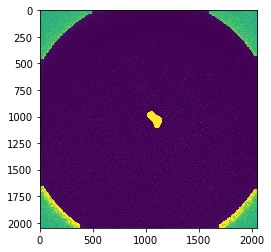

In [240]:
plt.imshow(nucs[:,:,1])

In [266]:
lbl_stk = np.stack(lbl.Labels['nuc'].values(), axis=2)

In [267]:
stkshow(lbl_stk, fname='/Users/rfor10/Downloads/nucs.tif')

In [208]:
tvec

(array([ 41., -19.]), 0.35087458178333114, -7.741226911703399e-17)

In [49]:
sum(nuc)

4822

In [11]:
# Segment imports
import warnings
import numpy
from scipy.ndimage import binary_fill_holes, binary_erosion, distance_transform_edt, binary_closing, binary_dilation
from scipy.ndimage import binary_dilation
from skimage.morphology import remove_small_objects, disk, erosion, watershed
from skimage import filters, img_as_uint
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
# from skfmm import distance
# Tracking imports
import lap

# Cell Label imports
import numpy
import numpy as np
from scipy.sparse import bsr_matrix
from scipy.spatial import KDTree, distance_matrix, distance
from collections import Counter, defaultdict

def parseVarargin(varargin, arg):
    for k, v in varargin.items():
        if k in arg:
            arg[k] = v
        else:
            raise TypeError('Argument not a default type.')
    return arg

#Segment Nuclei 20X
class CellLabel(object):
    def __init__(self, pth):
        self.T = []
        self.Reg = None
        self.saveToFile = False
        self.posname = []
        self.pth = pth
        self.cell2exclude = []
        self.spacedims = 2;
        self.tracked = None
        self.useCC = False
        self.cell_ids = []
        
        self.Labels = defaultdict(dict)
    
    def getXY(self, T, labeltype='nuc', return_as='dict', varargin={}):
        if T not in self.Labels[labeltype]:
            pass
        lbl = self.Labels[labeltype][T]
        regprops = regionprops(lbl)
        if return_as=='dict':
            return {p['label']: p['centroid'] for p in regprops}
#             if len(self.Labels)>0:
#                 warnings.warn('Timestamp not found in labels. Returning nearest.')
#             else:
    def relabel(self, tracks, labeltype='nuc'):
        lbls = self.Labels[labeltype]
        for tp_i, l in lbls.items():
            newlbl = np.zeros_like(l)
            props = regionprops(l)
            lbl_coords = {p.centroid: p.coords for p in props}
            for tp_centroid, newlbl_id in tracks.items():
                for tp_j, centroid in tp_centroid:
                    if tp_i == tp_j:
                        for coord in lbl_coords[centroid]:
                            newlbl[coord[0], coord[1]] = newlbl_id
                    else:
                        continue
            lbls[tp_i] = newlbl
        #return lbls

    
    def trackLabels(self, labeltype='nuc', max_displacement=50,
                    max_discontinuity=3):
        lbls = {tp: list(self.getXY(tp).values())
                for tp in self.Labels[labeltype].keys()}
        
        if len(lbls)==0:
            raise ValueError("No labels to track.")
        elif len(lbls)==1:
            warnings.warn("There is only one label so nothing was tracked.")
            return
        timepoints = sorted(list(lbls.keys()))
        consecutive_tp_pairs = [(timepoints[i], timepoints[i+1])
                        for i in range(len(timepoints)-1)]
        tp2idx = {tp:i for i, tp in enumerate(timepoints)}
        tracks = []
        trackdict = {}
        # Loop over all consecutive timepoints and use LAP to track
        for ti, tj in consecutive_tp_pairs:
            lbl_i, lbl_j = lbls[ti], lbls[tj] # Assuming these are centroids
            cost_matrix = distance_matrix(lbl_i, lbl_j)
            total_cost, column2row, row2column = lap.lapjv(cost_matrix,
                                                           cost_limit=max_displacement,
                                                           extend_cost=True)
            for col, row in enumerate(column2row):
                if row == -1:
                    tracks.append(([ti], [lbl_i[col]])) # time and xy
                    trackdict[(ti, tuple(lbl_i[col]))] = -1
                else:
                    tracks.append(([ti, tj], [lbl_i[col], lbl_j[row]]))
#                     if distance.euclidean(tuple(lbl_i[col]), tuple(lbl_j[row]))>max_displacement:
#                         print((ti, tuple(lbl_i[col])),  (tj, tuple(lbl_j[row])))
#                         return cost_matrix, row, col
                    trackdict[(ti, tuple(lbl_i[col]))] = (tj, tuple(lbl_j[row]))
        # Merge all pairs that link together into merged track
        merged_tracks = []
        for k, v in list(trackdict.items()):
            if v in trackdict:
                merged_track = [k]
                while v in trackdict:
        #             print(k, v)
                    merged_track += [v]
                    trackdict.pop(k)
                    k = v
                    v = trackdict[v]
                trackdict.pop(k)
                if not v == -1:
                    merged_track += [v]
                merged_tracks.append(merged_track)
        # Remove complete tracks from further linking
        incomplete_tracks = [t for t in merged_tracks if len(t)<len(lbls)]
        tracks = incomplete_tracks

        track_starts = np.array([i[0][0] for i in tracks])
        track_ends = np.array([i[-1][0] for i in tracks])

        track_xy_start = np.array([i[0][1] for i in tracks])
        track_xy_end = np.array([i[-1][1] for i in tracks])
        
        # Try to link more tracks by allowing gaps within track
        n = len(tracks)
        cc = [] # Finite costs
        ii = [] # indices of rows
        kk = []
        gap_cost_mat = np.ones((n, n))*(max_displacement+1) # this should be bigger than max_displacement
        for idx, trck in enumerate(tracks):
            tstart = trck[0][0]
            tend = trck[-1][0]
            xy_start = trck[0][1]
            xy_end = trck[-1][1]
            tracks_starting_after_this_ends = np.where((track_starts>tend) & (track_starts<tend+max_discontinuity))[0]
            if len(tracks_starting_after_this_ends)>0:
                start_tree = KDTree(track_xy_start[tracks_starting_after_this_ends])
                possmerge_start = start_tree.query(xy_end, k=50, distance_upper_bound=max_displacement)
                for d, tidx in zip(possmerge_start[0], possmerge_start[1]):
        #             if idx == tidx:
        #                 continue
                    if d>max_displacement:
                        break
                    else:
                        cc.append(d)
                        ii.append(idx)
                        kk.append(tidx)
                        gap_cost_mat[idx, tracks_starting_after_this_ends[tidx]] = d
            tracks_ending_before_this_track = np.where((track_ends<tstart) & (track_ends>tstart-max_discontinuity))[0]
            if len(tracks_ending_before_this_track)>0:
                end_tree = KDTree(track_xy_end[tracks_ending_before_this_track])
                possmerge_end = end_tree.query(xy_start, k=50, distance_upper_bound=max_displacement)
                for d, tidx in zip(possmerge_end[0], possmerge_end[1]):
        #             if idx == tidx:
        #                 continue
                    if d>max_displacement:
                        break
                    else:
                        cc.append(d)
                        ii.append(idx)
                        kk.append(tidx)
                        gap_cost_mat[idx, tracks_ending_before_this_track[tidx]] = d


        a,b,c = lap.lapjv(gap_cost_mat, cost_limit=max_displacement,
                          extend_cost=True)
        leftover_merges = []
        for idx, i in enumerate(c):
            if i == -1:
                continue
            track_i = tracks[idx]
            track_j = tracks[i]
            leftover_merges.append(track_i+track_j)
        # Build final output and ensure there are no duplicate tracks
        final_tracks = {}
        track_id = 1
        for track in merged_tracks+leftover_merges:
            track = tuple(sorted(track, key=lambda x: x[0]))
            if track not in final_tracks:
                final_tracks[track] = track_id
                track_id += 1
        self.tracks = final_tracks
        return final_tracks
    #print(merged_xys)
    
    
            
    
    def addLabel(self, newlabel, labeltype, T, varargin={}):
        arg = dict()
        arg['posname'] = 'None'
        arg['maxcelldistance'] = 25
        arg['relabel'] = None
        arg = parseVarargin(varargin, arg)
        
        newlabel = newlabel.astype(numpy.uint16)
        self.Labels[labeltype][T] = newlabel
        
#         if arg['relabel'] == 'lapjv':
            
#         if arg['relabel'] == 'nearest':
#             nlabels = len(self.Labels)
#             if nlabels==0:
#                 self.Labels[T] = bsr_matrix(newlabel)
#                 return
#             elif nlabels==1:
#                 if self.Labels.keys()[0] == T:
#                     self.Labels[T] = bsr_matrix(newlabel)
#                     print('Warning - added a newlabel with same timestamp as preexisting label. Preexisting label was overwritten.')
#                 else:
#                     existing_t = self.Labels.keys()
#                     dist2existing = numpy.abs(numpy.subtract(existing_t, T))
#                     nearest_t = existing_t[numpy.argmin(dist2existing)]
#                     self.Labels[T] = bsr_matrix(self._relabel_nearest(newlabel, nearest_t))
#             elif nlabels>1:
#                 if T in self.Labels.keys():
#                     print('Warning - added a newlabel with same timestamp as preexisting label. Preexisting label was overwritten.')
#                     existing_t = self.Labels.keys()
#                     dist2existing = numpy.abs(numpy.subtract(existing_t, T))
#                     secondNearest_t = existing_t[numpy.argsort(dist2existing)[1]]
#                     self.Labels[T] = bsr_matrix(self._relabel_nearest(newlabel, secondNearest_t))
#                 else:
#                     existing_t = self.Labels.keys()
#                     dist2existing = numpy.abs(numpy.subtract(existing_t, T))
#                     nearest_t = existing_t[numpy.argmin(dist2existing)]
#                     self.Labels[T] = bsr_matrix(self._relabel_nearest(newlabel, nearest_t))
#             self.tracked = True
#         cell_ids = set(range(100000))
#         for t, label in self.Labels.items():
#             label = label.toarray()
#             ids = set(label.flatten())
#             cell_ids = cell_ids.intersection(set(ids))
#         cell_ids.difference_update(set([0]))
#         self.cell_ids = list(cell_ids)
            
    def _relabel_nearest(self, newlabel, nearest_t, varargin={}):
        arg = dict()
        arg['maxcelldistance'] = 25
        nearest_label = self.Labels[nearest_t]
        if isinstance(nearest_label, bsr_matrix):
            nearest_label = nearest_label.toarray()
        nearest = [(p.label, p.centroid, p.coords) for p in regionprops(nearest_label)]
        nearest_label, nearest_xy, coords = zip(*nearest)
        new = [(p.label, p.centroid, p.coords) for p in regionprops(newlabel)]
        new_label, new_xy, _ = zip(*new)
        labels_coords = {k:v for k, _, v in new}
        knntree = KDTree(nearest_xy)
        dists, idx = knntree.query(new_xy, k=2, eps=arg['maxcelldistance'])
        qdata = zip(new_label, dists, idx)
        label_map = {}
        for newlbl_idx, d, j in qdata:
            if d[0]>arg['maxcelldistance']:
                label_map[newlbl_idx] = 0
            else:
                label_map[newlbl_idx] = nearest_label[j[0]]
        counts = Counter(label_map.values())
        for l, c in counts.items():
            if c>1:
                label_map[l] = 0
        if 0 in counts:
            del counts[0]
        if 0 in label_map:
            del label_map[0]
        if counts.most_common(1)>1:
            print('Warning two cells were assigned the same label.', counts.most_common(4))
        for k, v in label_map.items():
            try:
                coords = labels_coords[k]
            except:
                print(k)
            for x, y in coords:
                newlabel[x, y] = v
        
        return bsr_matrix(newlabel)
    
    def applyFuncPerLabel(self, stk, T, func=numpy.mean, varargin={},
                          outtype='matrix'):
        assert stk.shape[2]==len(T)
        label_values = defaultdict(list)
        label_timestamps = self.Labels.keys()
        label_props = {t:regionprops(self.Labels[t].toarray()) for t in label_timestamps}
        label_map = {}
        for t in T:
            label_map[t] = label_timestamps[numpy.argsort(numpy.subtract(label_timestamps, t))[0]]
        data = numpy.zeros((len(self.cell_ids), len(T)))
        label_to_idx = {j:idx for idx, j in enumerate(self.cell_ids)}
        for idx, t in enumerate(T):
            props = label_props[label_map[t]]
            for p in props:
                if p.label not in self.cell_ids:
                    continue
                #get_vals(stk[:,:,idx], p.coords)
                vals = [stk[x,y,idx] for x,y in p.coords]
                data[label_to_idx[p.label], idx] = func(vals)
                label_values[p.label].append((t*1440, func(vals)))
        if outtype=='matrix':
            return data
        elif outtype=='dict':
            return label_values

def segmentNucleiOnly(nuc, varargin={}):
    ## define analysis parameters
    # parameters for nuclei detection
    arg = dict()
    arg['nuc_erode'] = disk(4); # initial erosion to enhance nuclei centers
    arg['nuc_smooth'] = 14; # filtering to smooth it out
    arg['nuc_suppress'] = 0.05; # supression of small peaks - units are in a [0 1] space
    arg['nuc_minarea'] = 30; # smaller then this its not a nuclei
    arg['nuc_maxarea'] = float('inf'); 
    arg['nuc_stretch'] = [1, 99]; 
    arg['nuc_channel'] = 'DeepBlue';
    arg['mindistancefromedge'] =150;
    arg['shrinkmsk'] = disk(50);
    arg['removetopprcentile'] = 0; 
#     arg.['positiontype'] = 'Position'; 
    arg['register'] = []; # optional registration object
    arg['registerreference'] = []; 
#     arg['timefunc'] = lambda t: np.true(t.shape);
    arg['project'] = False; 
    arg['specificframeonly'] = []; # will duplicate that frame for all timepoints
    arg['singleframe'] = False; # must be used in conjunction with specificframeonly. IF true will only return single timepoint
    arg['track_method'] = 'none';
    arg['threshold_method'] = 'otsu';

    arg = parseVarargin(varargin,arg);
    
    #nuc = MD.stkread(Position=well,Channel=arg['nuc_channel'], sortby='TimestampFrame')#,'timefunc',arg.timefunc);
#     nuc_t = MD.image
    NucLabels = numpy.zeros(nuc.shape, dtype=int)

#     nucprj = numpy.mean(nuc,2);
#     msk_lower = nucprj>numpy.percentile(nucprj.flatten(),5)
#     msk_upper = nucprj<=numpy.percentile(nucprj.flatten(),100-arg['removetopprcentile']);
#     msk = msk_lower and msk_upper
    
#     del msk_lower, msk_upper
    
#     msk = binary_fill_holes(msk);
#     msk  = remove_small_objects(msk, min_size=10000, connectivity=2);
#     if not arg['shrinkmsk'] is False:
#         msk[0,:]=0; 
#         msk[:,0]=0; 
#         msk[-1,:]=0; 
#         msk[:,-1]=0; 
#         msk = binary_erosion(msk,arg['shrinkmsk']); 


#     bnd=bwboundaries(msk);
#     bnd=bnd{1}(:,[2 1]);
    for i in range(nuc.shape[2]):
        current_img = nuc[:,:,i]
        nucbw = current_img > filters.threshold_otsu(current_img)
        nucbw = binary_closing(nucbw, disk(2))
        nucbw = binary_fill_holes(nucbw, disk(5))
        nucpeaks = erosion(current_img, arg['nuc_erode'])
        nucpeaks = filters.gaussian(nucpeaks, sigma=arg['nuc_smooth'])
        nucpeaks = numpy.clip(nucpeaks, numpy.percentile(nucpeaks, 1), 
                         numpy.percentile(nucpeaks, 99))
        nucpeaks = numpy.divide(nucpeaks, float(numpy.amax(nucpeaks)))
        numpy.place(nucpeaks, ~nucbw, 0)
        dist_img = distance(nucpeaks)
        nucpeaks_max = peak_local_max(dist_img, min_distance=10)#, threshold_abs=arg['nuc_suppress'])
        peak_img = numpy.zeros(current_img.shape)
        for yx in nucpeaks_max:
            peak_img[yx[0], yx[1]] = 1
        peak_labels = label(peak_img)
        props = regionprops(peak_labels)
        for p in props:
            if p.area==1:
                continue
            elif p.area==2:
                peak_img[p.coords[0][0], p.coords[0][1]] = 0
            elif p.area>2:
                centroid = p.centroid
                pcenter = np.argmin([np.sum(np.abs(centroid - jj)) for jj in p.coords])
                for idx, xy in enumerate(p.coords):
                    if not idx == pcenter:
                        peak_img[xy[0], xy[1]] = 0
        labels = label(peak_img)
        lbls = watershed(dist_img*-1, labels, connectivity=1, watershed_line=True, mask=nucbw)
#         return dist_img, lbls, nucpeaks, numpy.multiply(lbls, peak_img)
        lbls = binary_erosion(lbls, disk(3))
        lbls = binary_dilation(lbls, disk(2))
        lbls = label(lbls)
        lbls = remove_small_objects(lbls, arg['nuc_minarea'])
#         lbls = binary_opening(lbls, disk(4))
        NucLabels[:,:,i] = lbls
    return NucLabels

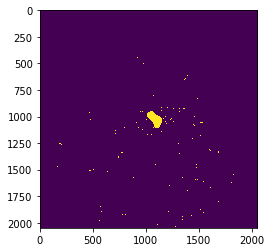

In [28]:
plt.imshow(cur_nuc>np.percentile(cur_nuc, 99.5))

In [32]:
from stkshow import stkshow

In [48]:
stkshow(smoothed_nuc, fname='/Users/rfor10/Downloads/tmp.tif')

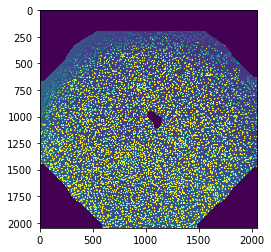

In [42]:
plt.imshow(imadjust(smoothed_nuc, 0.1, 0.9))

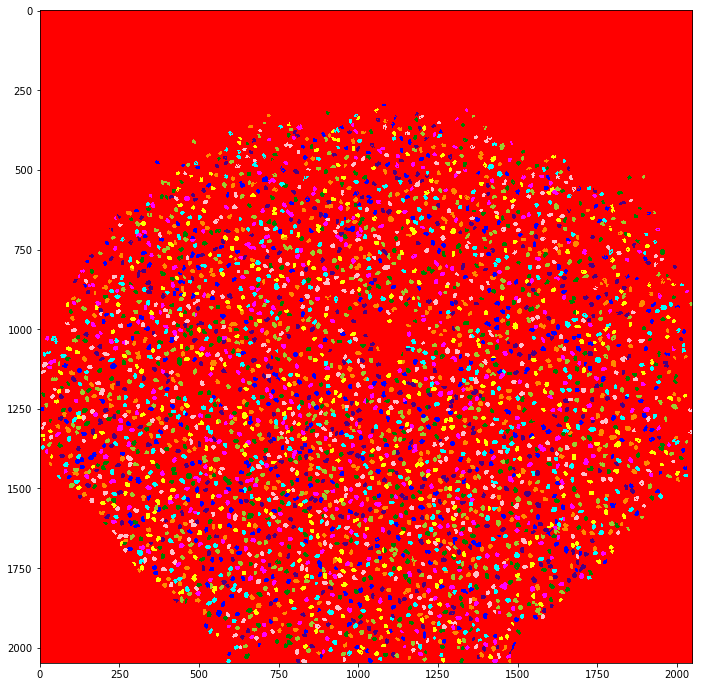

In [222]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(imadjust(label2rgb(nuc_lbls), 0.1, 0.99))
# x, y = zip(*nuc_peaks)
# plt.scatter(y, x, alpha=0.7, c='m', marker='x')

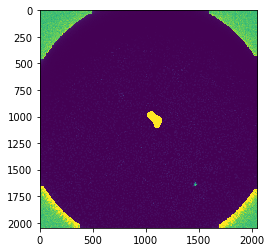

In [106]:
n = nucs[:,:,0]
plt.imshow(imadjust(n, 0.05, 0.99))

In [73]:
from skimage.filters import threshold_otsu

In [92]:
n.dtype

dtype('float64')

In [98]:
sum(n==float('inf'))

116

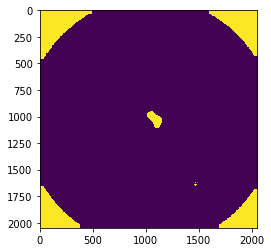

In [107]:
plt.imshow(n>threshold_otsu(n))

In [ ]:
def segment_nuclei_lowmag(nucs):
    